In [ ]:
# default_exp modeling.seq2seq.summarization


In [ ]:
# all_slow


In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.seq2seq.summarization

> This module contains custom models, custom splitters, etc... summarization tasks.

In [ ]:
# export
import inspect, torch
from typing import Callable, Dict, List, Optional, Union

from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoaders
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from fastcore.all import *
from transformers import AutoModelForSeq2SeqLM, PreTrainedModel, logging 

from blurr.utils import BLURR
from blurr.data.seq2seq.core import Seq2SeqBatchTokenizeTransform, Seq2SeqTextBlock
from blurr.modeling.core import BaseModelCallback, BaseModelWrapper, Blearner, PreCalculatedCrossEntropyLoss
from blurr.modeling.seq2seq.core import Seq2SeqMetricsCallback, blurr_seq2seq_splitter

logging.set_verbosity_error()


In [ ]:
# hide_input
import ast, os, inspect, pdb
from functools import reduce

from datasets import load_dataset
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastcore.test import *
from nbdev.showdoc import show_doc
from transformers import BartForConditionalGeneration

from blurr.utils import print_versions

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")


What we're running with at the time this documentation was generated:
torch: 1.10.1+cu111
fastai: 2.5.3
transformers: 4.16.2


In [ ]:
# cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: GeForce GTX 1080 Ti


## Mid-level API

### Example

The objective of summarization is to generate a concise and accurate representation of a much larger body of text.  For example, we may want to summarize an article in a single sentence.

In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1000]")
cnndm_df = pd.DataFrame(dataset)
cnndm_df.head(2)

Reusing dataset cnn_dailymail (/home/wgilliam/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef


In [ ]:
# hide

# pretrained_model_name = "t5-small"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name,
#                                                                   model_cls=T5ForConditionalGeneration)

# pretrained_model_name = "google/pegasus-cnn_dailymail"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name,
#                                                                   model_cls=PegasusForConditionalGeneration)

# pretrained_model_name = "facebook/bart-large-cnn"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name,
#                                                                   model_cls=BartForConditionalGeneration)


In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)


('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
text_gen_kwargs = {}
if hf_arch in ["bart", "t5"]:
    text_gen_kwargs = {**hf_config.task_specific_params["summarization"], **{"max_length": 30, "min_length": 10}}

# not all "summarization" parameters are for the model.generate method ... remove them here
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs.copy():
    if k not in generate_func_args:
        del text_gen_kwargs[k]

if hf_arch == "mbart":
    text_gen_kwargs["decoder_start_token_id"] = hf_tokenizer.get_vocab()["en_XX"]


In [ ]:
tok_kwargs = {}
if hf_arch == "mbart":
    tok_kwargs["src_lang"], tok_kwargs["tgt_lang"] = "en_XX", "en_XX"


In [ ]:
batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch,
    hf_config,
    hf_tokenizer,
    hf_model,
    max_length=256,
    max_target_length=130,
    tok_kwargs=tok_kwargs,
    text_gen_kwargs=text_gen_kwargs,
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader("article"), get_y=ColReader("highlights"), splitter=RandomSplitter())


In [ ]:
dls = dblock.dataloaders(cnndm_df, bs=2)


In [ ]:
b = dls.one_batch()


In [ ]:
len(b), b[0]["input_ids"].shape, b[1].shape


(2, torch.Size([2, 256]), torch.Size([2, 57]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)


,text,target
0,"<s> (CNN) -- When Ji Yeqing awakened, she was already in the recovery room. Chinese authorities had dragged her out of her home and down four flights of stairs, she said, restraining and beating her husband as he tried to come to her aid. They whisked her into a clinic, held her down on a bed and forced her to undergo an abortion. Her offense? Becoming pregnant with a second child, in violation of China's one-child policy. ""After the abortion, I felt empty, as if something was scooped out of me,"" Ji told a congressional panel in September. ""My husband and I had been so excited for our new baby. Now suddenly all that hope and joy and excitement disappeared.... I was very depressed and despondent. For a long time, whenever I thought about my lost child, I would cry."" As she lay unconscious, she said, an IUD to prevent future pregnancies was inserted. The issue of forced abortions -- and in some cases, forced sterilizations -- in China has seized the spotlight in recent days with news of escaped activist Chen Guangcheng. Chen, a blind, self-taught lawyer, rose to fame in the late 1990s because of his advocacy for what he calls victims</s>","China's one-child policy results in forced abortions and sterilizations, activists say.\nWomen tell of emotional and physical consequences from the procedures.\nActivist Chen Guangcheng works to advocate for victims of such practices."
1,"<s> (CNN) -- The generation of gays and lesbians that literally created the modern LGBT movement -- from the heroes of the 1969 Stonewall riots to their slightly younger friends -- is at, or nearing, retirement age. That used to mean the beginning of an extremely difficult time in an LGBT person's life. But as gay baby boomers find more acceptance in mainstream society and continue to do what they've always done -- push to make a better world for the LGBT community -- their retirement options are slowly improving. That is, if they decide to retire at all. ""The notion of retirement has never been a part of my vocabulary,"" said Bob Witeck, CEO and co-founder of Witeck Communications. Nearly 61, Witeck has put some thought into what he should do with his strategic public relations and marketing firm as he gets older. Like many friends his age who are also entrepreneurs, he plans to keep working. ""Because I run a business, as I get older I can change the intensity of my engagement in the kinds of work I take on,"" Witeck said. ""I know I'm lucky that way, and I'm lucky in my personal life as well. My husband is 50, so I have a younger man to help me</s>","LGBT baby boomers changed the visibility of the gay community.\nAs they approach retirement, they face different obstacles than their straight counterparts.\nWithout marriage equality, same-sex couples may face financial hardships.\nAdvocates say the situation is slowly improving."


#### Training

In [ ]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    },
    "bertscore": {"compute_kwargs": {"lang": "en"}, "returns": ["precision", "recall", "f1"]},
}


In [ ]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),  # PreCalculatedLoss()
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
) 

# learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()


In [ ]:
# hide
# learn.summary()


In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds), preds["loss"].shape, preds["logits"].shape


(4, torch.Size([]), torch.Size([2, 56, 50264]))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape


(2, 3, torch.Size([2, 256]), 2, torch.Size([2, 56]))

In [ ]:
print(len(learn.opt.param_groups))


3


SuggestedLRs(minimum=6.918309954926372e-05, steep=2.75422871709452e-06, valley=5.248074739938602e-05, slide=0.005248074419796467)

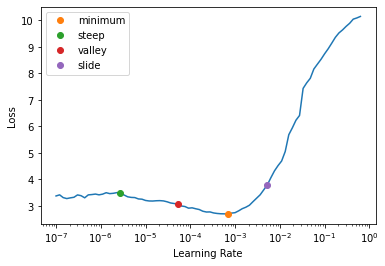

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
learn.fit_one_cycle(1, lr_max=4e-5, cbs=fit_cbs)


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.927012,1.697554,0.319421,0.151835,0.249308,0.297531,0.893816,0.865174,0.879149,02:02


#### Showing results

And here we create a `@typedispatch`ed implementation of `Learner.show_results`.

In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)


,text,target,prediction
0,"Hong Kong (CNN) -- When American pop artist Andy Warhol visited Beijing in 1982 and was told there wasn't a McDonald's, he replied: ""Oh, but they will."" Twenty-six years after his death, Warhol, whose much-lauded prescience extended across visual and consumer culture, has popped up in China once again -- and he was right about the fast-food chain. ""Andy Warhol: 15 Minutes Eternal,"" the first major retrospective of his work in China, recently arrived in Shanghai with the aim of acquainting the C","First major retrospective of pop artist Andy Warhol's work exhibiting in China.\nWarhol made first and only trip to China in 1982, which provided artistic inspiration.\nWhile iconic works are well-recognized in China, few people connect them with Warh","""Andy Warhol: 15 Minutes Eternal,"" first major retrospective of his work in China .\nWarhol's engagement with the country started"
1,"(CNN) -- Former U.S. Sen. Arlen Specter, who embodied a vanishing breed of liberal Republicanism before switching to the Democratic Party at the twilight of his political career, died Sunday after a long battle with cancer, his family announced. Specter died of complications from non-Hodgkin's lymphoma at his home in Philadelphia, his family said. He was 82. The veteran Pennsylvania politician had overcome numerous serious illnesses over the past two decades, including a brain tumor. He had bee","NEW: Vice President Joe Biden praises ""my friend,"" plans to attend funeral Tuesday.\nSpecter died of complications from non-Hodgkin's lymphoma.\nHe represented Pennsylvania in the Senate longer than anyone else.\nHe was long one of the most prominent J",NEW: Former Sen. Arlen Specter dies of complications from non-Hodgkin's lymphoma .\nSpect


#### Prediction

We add here `Learner.blurr_summarize` method to bring the results inline with the format returned via Hugging Face's pipeline method

In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""


In [ ]:
outputs = learn.blurr_generate(test_article, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f"=== Prediction {idx+1} ===\n{o}\n")


=== Prediction 1 ===
 A woman driving by unknowingly blocks the robbers' vehicles, a police officer says .
The robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning .
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the robbers .

=== Prediction 2 ===
 A woman driving by unknowingly blocks the robbers' vehicles, a police officer says .
The robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning .
There were about 600 people in the casino at the time of the robbery .
No serious injuries were reported .

=== Prediction 3 ===
 A woman driving by unknowingly blocks the robbers' vehicles, a police officer says .
The robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning .
There were no serious injuries, although one guest was kicked in the head by one of the robbers .



In [ ]:
# export
@patch
def blurr_summarize(self: Learner, inp, **kwargs):
    preds = learn.blurr_generate(inp, **kwargs)
    return [{"summary_text": pred} for pred in preds]

In [ ]:
learn.blurr_summarize(test_article, num_return_sequences=3)

[{'summary_text': " A woman driving by unknowingly blocks the robbers' vehicles, a police officer says .\nThe robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning .\nThere were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the robbers ."},
 {'summary_text': " A woman driving by unknowingly blocks the robbers' vehicles, a police officer says .\nThe robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning .\nThere were about 600 people in the casino at the time of the robbery .\nNo serious injuries were reported ."},
 {'summary_text': " A woman driving by unknowingly blocks the robbers' vehicles, a police officer says .\nThe robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning .\nThere were no serious injuries, although one guest was kicked in the head by one of the robbers ."}]

#### Inference

Using fast.ai `Learner.export` and `load_learner`

In [ ]:
export_fname = "summarize_export"


In [ ]:
learn.metrics = None
learn.export(fname=f"{export_fname}.pkl")


In [ ]:
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_summarize(test_article)


[{'summary_text': " A woman driving by unknowingly blocks the robbers' vehicles, a police officer says .\nThe robbers made off with several hundred"}]

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


## High-level API

### `BlearnerForSummarization`

We also introduce a task specific `Blearner` that get you your DataBlock, DataLoaders, and BLearner in one line of code!

In [ ]:
# export
@delegates(Blearner.__init__)
class BlearnerForSummarization(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        super().__init__(dls, hf_model, **kwargs)

    @classmethod
    def get_model_cls(cls):
        return AutoModelForSeq2SeqLM

    @classmethod
    def _add_t5_prefix(cls, inp):
        return f"summarize: {inp}"

    @classmethod
    def get_metrics_cb(self):
        seq2seq_metrics = {
            "rouge": {
                "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
                "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
            },
            "bertscore": {"compute_kwargs": {"lang": "en"}, "returns": ["precision", "recall", "f1"]},
        }

        return Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)

    @classmethod
    def from_data(
        cls,
        # Your raw dataset. Supports DataFrames, Hugging Face Datasets, as well as file paths 
        # to .csv, .xlsx, .xls, and .jsonl files
        data: Union[pd.DataFrame, Path, str, List[Dict]],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your target (summarized) text
        summary_attr: str = "summary",
        # The max length of your raw text to consider for summarization
        max_length: Union[int, str] = None,
        # The max length of your targets (sumamrized) text
        max_target_length: Union[int, str] = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Optional[Callable] = None,
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs: dict = {},
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs: dict = {},
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs: dict = {},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs: dict = {},
    ):
        # if we get a path/str then we're loading something like a .csv file
        if isinstance(data, Path) or isinstance(data, str):
            content_type = mimetypes.guess_type(data)[0]
            if content_type  == 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet': 
                data = pd.read_excel(data)
            elif content_type  == 'text/csv': 
                data = pd.read_csv(data)
            elif content_type  == 'application/json': 
                data = pd.read_json(data, orient='records')
            else: 
                raise ValueError("'data' must be a .xlsx, .xls, .csv, or .jsonl file")

            data = pd.read_csv(data)

        # infer our datablock splitter if None
        if dblock_splitter is None:
            dblock_splitter = ColSplitter() if hasattr(data, "is_valid") else RandomSplitter()

        # we need to find the architecture to ensure "mbart" specific tokenizer kwargs are included
        model_cls = cls.get_model_cls()
        model = model_cls.from_pretrained(pretrained_model_name_or_path)
        hf_arch = BLURR.get_model_architecture(type(model).__name__)

        if hf_arch == "mbart":
            hf_tok_kwargs = {**{"src_lang": "en_XX", "tgt_lang": "en_XX"}, **hf_tok_kwargs}

        # get our hf objects
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
            pretrained_model_name_or_path, model_cls=model_cls, tokenizer_kwargs=hf_tok_kwargs
        )

        # update text generation kwargs
        if text_gen_kwargs is None and hf_arch in ["bart", "t5"]:
            text_gen_kwargs = hf_config.task_specific_params["summarization"]

        # not all "summarization" parameters are for the model.generate method ... remove them here
        generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
        for k in text_gen_kwargs.copy():
            if k not in generate_func_args:
                del text_gen_kwargs[k]

        # update our text generation kwargs for mbart
        if hf_arch == "mbart":
            text_gen_kwargs = {**{"decoder_start_token_id": "en_XX"}, **text_gen_kwargs}

        # define getters
        get_x = Pipeline(funcs=[ItemGetter(text_attr)])
        get_y = ItemGetter(summary_attr)

        if hf_arch == "t5":
            get_x.add(cls._add_t5_prefix)

        # define our DataBlock and DataLoaders
        batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
            hf_arch,
            hf_config,
            hf_tokenizer,
            hf_model,
            max_length=max_length,
            max_target_length=max_target_length,
            text_gen_kwargs=text_gen_kwargs,
        )

        blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)
        dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=get_y, splitter=dblock_splitter)

        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance
        learner_kwargs["splitter"] = learner_kwargs.pop("splitter", partial(blurr_seq2seq_splitter, arch=hf_arch))
        learner_kwargs["loss_func"] = learner_kwargs.pop("loss_func", PreCalculatedCrossEntropyLoss())

        return cls(dls, hf_model, **learner_kwargs.copy())

#### Example

In [ ]:
learn = BlearnerForSummarization.from_data(
    cnndm_df,
    "facebook/bart-large-cnn",
    text_attr="article",
    summary_attr="highlights",
    max_length=256,
    max_target_length=130,
    dblock_splitter=RandomSplitter(),
    dl_kwargs={"bs": 2},
).to_fp16()


In [ ]:
learn.fit_one_cycle(1, lr_max=4e-5, cbs=[BlearnerForSummarization.get_metrics_cb()])


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.799723,1.766168,0.393318,0.172341,0.270261,0.369094,0.880527,0.895940,0.888071,03:16


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)


,text,target,prediction
0,"(CNN) -- The generation of gays and lesbians that literally created the modern LGBT movement -- from the heroes of the 1969 Stonewall riots to their slightly younger friends -- is at, or nearing, retirement age. That used to mean the beginning of an extremely difficult time in an LGBT person's life. But as gay baby boomers find more acceptance in mainstream society and continue to do what they've always done -- push to make a better world for the LGBT community -- their retirement options are s","LGBT baby boomers changed the visibility of the gay community.\nAs they approach retirement, they face different obstacles than their straight counterparts.\nWithout marriage equality, same-sex couples may face financial hardships.\nAdvocates say the s","Bob Witeck, 61, runs a public relations and marketing firm .\nHe plans to keep working as he gets older .\n""The notion of retirement has never been a part of my vocabulary,"" he says .\nWiteck is one of many gay baby boomers who started the modern LGBT"
1,"Washington (CNN) -- In one ill-fated fundraiser, Mitt Romney managed to offend Palestinians, Latinos and some of the same people he's counting on for support if he wants to unseat President Barack Obama. It isn't the first time Romney's oratory fumbles have put his campaign on its heels, handed opponents material to push the stereotype of him as an out-of-touch businessman and provoked members of the party's conservative base to question his worthiness as their standard-bearer. ""Everybody has t","GOP presidential candidate Mitt Romney's verbal gaffes have once again stymied his campaign's ability to control the narrative.\nDemocrats were gleeful, while Republicans left scrambling after Romney's comments.\nLess than two months before the electi","Mitt Romney's gaffes reinforce a sitcom-like caricature of the candidate, a political expert says .\nThe gaffe was recorded during a May 17 private fundraiser at the home of Sun Capital executive Marc Leder .\nRomney said his comments were ""off the cu"


In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""


In [ ]:
learn.blurr_summarize(test_article, num_return_sequences=3)

[{'summary_text': " Robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say .\nThe men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino .\nA woman driving by and unaware of what was happening unknowingly blocked the robbers' vehicles .\nShe was beaten and robbed by a gunman, who then took off for the French border .\nThere were about 600 people in the casino at the time of the robbery ."},
 {'summary_text': " Robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say .\nThe men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino .\nA woman driving by and unaware of what was happening unknowingly blocked the armed robbers' vehicles .\nShe was beaten and robbed by a gunman, who then took off for the French border ."},
 {'summary_text': " Robbers made off with several hundred thou

In [ ]:
export_fname = "summarize_export"

learn.metrics = None
learn = learn.to_fp32()
learn.export(fname=f"{export_fname}.pkl")

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_summarize(test_article)


[{'summary_text': " Robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say .\nThe men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino .\nA woman driving by and unaware of what was happening unknowingly blocked the robbers' vehicles .\nShe was beaten and robbed by a gunman, who then took off for the French border .\nThere were about 600 people in the casino at the time of the robbery ."}]

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


## Tests

The purpose of the following tests is to ensure as much as possible, that the core training code works for the pretrained **summarization models** below.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained summarization models you are working with ... and if any of your pretrained summarization models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
# hide
[model_type for model_type in BLURR.get_models(task="ConditionalGeneration") if (not model_type.startswith("TF"))]


['BartForConditionalGeneration',
 'BigBirdPegasusForConditionalGeneration',
 'BlenderbotForConditionalGeneration',
 'BlenderbotSmallForConditionalGeneration',
 'FSMTForConditionalGeneration',
 'LEDForConditionalGeneration',
 'M2M100ForConditionalGeneration',
 'MBartForConditionalGeneration',
 'MT5ForConditionalGeneration',
 'PegasusForConditionalGeneration',
 'ProphetNetForConditionalGeneration',
 'Speech2TextForConditionalGeneration',
 'T5ForConditionalGeneration',
 'XLMProphetNetForConditionalGeneration']

In [ ]:
# hide
pretrained_model_names = [
    "facebook/bart-base",
    #'facebook/blenderbot_small-90M',
    "allenai/led-base-16384",
    "sshleifer/tiny-mbart",
    "google/mt5-small",
    "sshleifer/distill-pegasus-cnn-16-4",
    "t5-small",
    #'microsoft/prophetnet-large-uncased',
    #'microsoft/xprophetnet-large-wiki100-cased', # XLMProphetNet
]


In [ ]:
# hide
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1000]")
cnndm_df = pd.DataFrame(dataset)
cnndm_df.head(2)


Reusing dataset cnn_dailymail (/home/wgilliam/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef


In [ ]:
# hide
model_cls = AutoModelForSeq2SeqLM
bsz = 2
inp_seq_sz = 64
trg_seq_sz = 40

test_results = []
for model_name in pretrained_model_names:
    error = None

    print(f"=== {model_name} ===\n")

    hf_tok_kwargs = {}
    if model_name == "sshleifer/tiny-mbart":
        hf_tok_kwargs["src_lang"], hf_tok_kwargs["tgt_lang"] = "en_XX", "en_XX"

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name, model_cls=model_cls, tokenizer_kwargs=hf_tok_kwargs)

    print(f"architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n")

    # 1. build your DataBlock
    text_gen_kwargs = {}
    if hf_arch in ["bart", "t5"]:
        text_gen_kwargs = {**hf_config.task_specific_params["summarization"], **{"max_length": 30, "min_length": 10}}

    # not all "summarization" parameters are for the model.generate method ... remove them here
    generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
    for k in text_gen_kwargs.copy():
        if k not in generate_func_args:
            del text_gen_kwargs[k]

    if hf_arch == "mbart":
        text_gen_kwargs["decoder_start_token_id"] = hf_tokenizer.get_vocab()["en_XX"]

    def add_t5_prefix(inp):
        return f"summarize: {inp}" if (hf_arch == "t5") else inp

    batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
        hf_arch,
        hf_config,
        hf_tokenizer,
        hf_model,
        padding="max_length",
        max_length=inp_seq_sz,
        max_target_length=trg_seq_sz,
        text_gen_kwargs=text_gen_kwargs,
    )

    blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)
    dblock = DataBlock(
        blocks=blocks, get_x=Pipeline([ColReader("article"), add_t5_prefix]), get_y=ColReader("highlights"), splitter=RandomSplitter()
    )

    dls = dblock.dataloaders(cnndm_df, bs=bsz)
    b = dls.one_batch()

    # 2. build your Learner
    seq2seq_metrics = {
        "rouge": {
            "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
            "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
        }
    }

    model = BaseModelWrapper(hf_model)
    learn_cbs = [BaseModelCallback]
    fit_cbs = [ShortEpochCallback(0.05, short_valid=True), Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

    learn = Learner(
        dls, model, opt_func=ranger, loss_func=PreCalculatedCrossEntropyLoss(), cbs=learn_cbs, splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)
    ).to_fp16()

    learn.create_opt()
    learn.freeze()

    # 3. Run your tests
    try:
        print("*** TESTING DataLoaders ***\n")
        test_eq(len(b), 2)
        test_eq(len(b[0]["input_ids"]), bsz)
        test_eq(b[0]["input_ids"].shape, torch.Size([bsz, inp_seq_sz]))
        test_eq(len(b[1]), bsz)

        #         print('*** TESTING One pass through the model ***')
        #         preds = learn.model(b[0])
        #         test_eq(preds[1].shape[0], bsz)
        #         test_eq(preds[1].shape[2], hf_config.vocab_size)

        print("*** TESTING Training/Results ***")
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=fit_cbs)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "PASSED", ""))
        learn.show_results(learner=learn, max_n=2, input_trunc_at=500, target_trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "FAILED", err))
    finally:
        # cleanup
        del learn
        torch.cuda.empty_cache()


=== facebook/bart-base ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Washington (CNN) -- In one ill-fated fundraiser, Mitt Romney managed to offend Palestinians, Latinos and some of the same people he's counting on for support if he wants to unseat President Barack Obama. It isn't the first time Romney's oratory fumbles have put his campaign on its heels","GOP presidential candidate Mitt Romney's verbal gaffes have once again stymied his campaign's ability to control the narrative.\nDemocrats were gleeful, while Republicans left scrambling after Romney's","WASHINGTON (CNN) -- In one ill-fated fundraiser, Mitt Romney managed to offend Palestinians, Latinos and some of the same people"
1,"(CNN) -- A spate of deadly shootings during anti-drug operations in Honduras -- including two in which U.S. agents killed suspects -- is linked to an aggressive new strategy to disrupt a preferred corridor for traffickers. Operation Anvil, as the multinational mission is known, differs from past efforts because of its","Six people have been killed in three incidents over the past two months in Honduras.\nThe incidents happened during the course of Operation Anvil, a joint Honduran-U.S. effort",(CNN) -- A spate of deadly shootings during anti-drug operations in Honduras -- including two in which U.S. agents killed


=== allenai/led-base-16384 ===

architecture:	led
tokenizer:	LEDTokenizerFast
model:		LEDForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"(CNN) -- The generation of gays and lesbians that literally created the modern LGBT movement -- from the heroes of the 1969 Stonewall riots to their slightly younger friends -- is at, or nearing, retirement age. That used to mean the beginning of an extremely difficult time in an LGBT person's life. But","LGBT baby boomers changed the visibility of the gay community.\nAs they approach retirement, they face different obstacles than their straight counterparts.\nWithout marriage equality, same-sex couples may face",(CNN) -- The generation of gays and lesbians that literally created the modern LGBT movement --
1,"Washington (CNN) -- The sister of presidential assailant John Hinckley Jr. testified Tuesday that she has seen no sign that her brother represents a danger to himself or others. Diane Sims, who said she loves her brother, said she supports a proposal that would expand his visits to their mother's home in Williams",NEW: Hospital staff makes release recommendations.\nJohn Hinckley's sister says she supports letting him eventually live in Williamsburg.\nShe says he feels comfortable there and is accepted by many,Washington (CNN) -- The sister of presidential assailant John Hinckley Jr. testified Tuesday


=== sshleifer/tiny-mbart ===

architecture:	mbart
tokenizer:	MBartTokenizerFast
model:		MBartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Few question that there was a major chemical attack in Syria last week, and the United States has made clear that it blames the government of President Bashar al-Assad. Now, the question is how President Barack Obama will respond. For almost two years, Obama has avoided direct military involvement in","U.S. evidence includes satellite imagery, official says. Obama is considering how to respond to Syrian chemical attack. Official: Obama could be presented with options within",เข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไป
1,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down"" Obama sends a letter to the heads of the House",เข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไป


=== google/mt5-small ===

architecture:	mt5
tokenizer:	T5TokenizerFast
model:		MT5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"(CNN) -- When Ji Yeqing awakened, she was already in the recovery room. Chinese authorities had dragged her out of her home and down four flights of stairs, she said, restraining and beating her husband as he tried to come to her aid","China's one-child policy results in forced abortions and sterilizations, activists say. Women tell of emotional and physical consequences from the procedures.",<extra_id_0>.
1,"Manchester, New Hampshire (CNN)New Jersey Gov. Chris Christie dominates almost any room he enters but is suddenly facing questions about his relevance in the 2016 presidential race. The surprisingly fast-moving Republican presidential contest, kicked off by Jeb Bush",Chris Christie was once the Republican establishment's favorite heading into 2016. But he could face challenges if Romney and Bush enter the race.,<extra_id_0>


=== sshleifer/distill-pegasus-cnn-16-4 ===

architecture:	pegasus
tokenizer:	PegasusTokenizerFast
model:		PegasusForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Washington (CNN) -- New details emerged of what the White House knew about the Internal Revenue Service targeting of conservative groups, with spokesman Jay Carney disclosing Chief of Staff Denis McDonough was among the top officials made aware of the matter late last month. In a new timeline provided by Carney to reporters on Monday, General Counsel Kathryn",A Senate committee holds a hearing Tuesday on the IRS targeting. White House discloses new details of what it knew about the IRS targeting report. White House spokesman says President Obama wasn't told,Chief of Staff Denis McDonough was among the top officials made aware of the IRS targeting of conservative groups . General Counsel Kathryn Kathryn says the IRS targeted conservative groups late last month .
1,"Few question that there was a major chemical attack in Syria last week, and the United States has made clear that it blames the government of President Bashar al-Assad. Now, the question is how President Barack Obama will respond. For almost two years, Obama has avoided direct military involvement in Syria's civil war","U.S. evidence includes satellite imagery, official says. Obama is considering how to respond to Syrian chemical attack. Official: Obama could be presented with options within days. A U",Obama has avoided direct military involvement in Syria's civil war for almost two years . Obama has avoided direct military involvement in Syria's civil war .


=== t5-small ===

architecture:	t5
tokenizer:	T5TokenizerFast
model:		T5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"summarize: Washington (CNN) -- New details emerged of what the White House knew about the Internal Revenue Service targeting of conservative groups, with spokesman Jay Carney disclosing Chief of Staff Denis McDonough was among the top officials made aware of the matter late last month. In a new",A Senate committee holds a hearing Tuesday on the IRS targeting. White House discloses new details of what it knew about the IRS targeting report. White House spokesman says President Obama,new details emerge of what the white house knew about the irs targeting of conservative groups . chief of staff denis McDonough
1,"summarize: (CNN) -- Sitting incongruously among the hangars and laboratories of NASA's Ames Research Center in Silicon Valley is the squat facade of an old McDonald's. You won't get a burger there, though -- its cash registers and","NASA-funded project has recovered 2,000 analog moon pictures. The images were taken by the five Lunar Orbiter images between 1966 and 1967. Project uses old and modern technology to",the squat facade of an old McDonald's in Silicon Valley sits among the hangars of NASA's Ames Research


In [ ]:
# hide_input
test_results_df = pd.DataFrame(test_results, columns=["arch", "tokenizer", "model_name", "result", "error"])
display_df(test_results_df)


,arch,tokenizer,model_name,result,error
0,bart,BartTokenizerFast,BartForConditionalGeneration,PASSED,
1,led,LEDTokenizerFast,LEDForConditionalGeneration,PASSED,
2,mbart,MBartTokenizerFast,MBartForConditionalGeneration,PASSED,
3,mt5,T5TokenizerFast,MT5ForConditionalGeneration,PASSED,
4,pegasus,PegasusTokenizerFast,PegasusForConditionalGeneration,PASSED,
5,t5,T5TokenizerFast,T5ForConditionalGeneration,PASSED,


## Summary

This module includes the fundamental bits to use Blurr for summarization tasks training and inference.

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()


Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
